# Telenet OOC

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import t, ttest_ind

# Series
### Load Data

In [195]:
series = pd.read_excel('query_result (64).xls')
series['date'] = series.timestamp.apply(lambda x: datetime.fromtimestamp(x/1000))
print len(series), 'records'
series.sort_values('customernumber', ascending=False).head()

3628 records


,customernumber,timestamp,programcrid,programseriesname,sessionrecordduration,date
2730,1029981160,1492552700000,crid://telenet.be/AA/TN00036628_02_0005-OSNL-SD,Ordinary Lies,37.850000,2017-04-18 23:58:20
2731,1029981160,1492549286000,crid://telenet.be/AA/TN00036628_02_0004-OSNL-SD,Ordinary Lies,23.116667,2017-04-18 23:01:26
2347,1029981160,1492381705000,crid://telenet.be/AA/TN00036628_02_0002-OSNL-SD,Ordinary Lies,48.150000,2017-04-17 00:28:25
2348,1029981160,1492380671000,crid://telenet.be/AA/TN00036628_02_0001-OSNL-SD,Ordinary Lies,17.133333,2017-04-17 00:11:11
2349,1029981160,1492304022000,crid://telenet.be/AA/TN00036628_02_0001-OSNL-SD,Ordinary Lies,51.616667,2017-04-16 02:53:42


In [196]:
header = ['customernumber', 'group', 'series', 'maildate']
mails = pd.read_excel('eval OOC triggers mail.xlsx', sheetname=2, names=header)
print len(mails), 'records'
mails.tail()

201 records


,customernumber,group,series,maildate
196,264411488,test,Ordinary Lies,2017-04-27
197,592780033,test,Ordinary Lies,2017-04-27
198,663266802,test,Ordinary Lies,2017-04-27
199,671609509,test,Ordinary Lies,2017-04-27
200,683208786,test,Ordinary Lies,2017-04-27


In [197]:
data = pd.merge(mails, series, on='customernumber')
data = data[data.series == data.programseriesname]
data = data[['customernumber', 'group', 'series', 'maildate', 'date', 'sessionrecordduration', 'programcrid']]
print len(data), 'records'
data.sort_values('date', ascending=False).head()

3611 records


,customernumber,group,series,maildate,date,sessionrecordduration,programcrid
485,723149245,test,Black-ish,2017-04-21,2017-04-30 23:42:58,20.716667,crid://telenet.be/AA/TN00037209_02_0006-OSNL-SD
483,723149245,test,Black-ish,2017-04-21,2017-04-30 23:22:23,20.500000,crid://telenet.be/AA/TN00037209_02_0005-OSNL-SD
482,723149245,test,Black-ish,2017-04-21,2017-04-30 23:01:40,20.633333,crid://telenet.be/AA/TN00037209_02_0004-OSNL-SD
484,723149245,test,Black-ish,2017-04-21,2017-04-30 22:40:51,20.716667,crid://telenet.be/AA/TN00037209_02_0003-OSNL-SD
493,723149245,test,Black-ish,2017-04-21,2017-04-30 22:26:00,14.566667,crid://telenet.be/AA/TN00037209_02_0002-OSNL-SD


### Retrieve viewing counts and minutes watched

Viewings splitted pre and post trigger

In [239]:
pre = data[(data.maildate - data.date) > pd.Timedelta(0)]
post = data[(data.maildate - data.date) <= pd.Timedelta(0)]

Number of unique serie viewings and total minutes watched grouped per customer

In [240]:
agg = {'group':'min', 'programcrid':'nunique', 'sessionrecordduration':'sum', 'maildate':'min'}
pre = pre.groupby(['customernumber']).agg(agg)
post = post.groupby(['customernumber']).agg(agg)
pre.head()

,maildate,programcrid,group,sessionrecordduration
customernumber,,,,
3070553,2017-04-27,29,test,635.850000
5748056,2017-04-21,28,test,521.250000
8823360,2017-04-21,3,test,152.800000
10664542,2017-04-21,34,test,681.316667
12230585,2017-04-21,13,test,246.366667


Merge pre and post to include zero values per customer

In [241]:
counts = pd.merge(pre, post, left_index=True, right_index=True, how='outer').fillna(0)
counts.drop(['group_y', 'maildate_y'], 1, inplace=True)
counts.columns=['maildate', 'precount', 'group', 'preminutes', 'postcount', 'postminutes']
counts.head(10)

,maildate,precount,group,preminutes,postcount,postminutes
customernumber,,,,,,
3070553,2017-04-27,29,test,635.850000,2.0,41.433333
5748056,2017-04-21,28,test,521.250000,0.0,0.000000
8823360,2017-04-21,3,test,152.800000,0.0,0.000000
10664542,2017-04-21,34,test,681.316667,4.0,82.300000
12230585,2017-04-21,13,test,246.366667,9.0,185.283333
13607581,2017-04-21,6,control,124.000000,0.0,0.000000
14710250,2017-04-21,8,test,160.750000,7.0,143.216667
15678735,2017-04-21,3,test,166.866667,0.0,0.000000
16645503,2017-04-21,5,test,257.233333,0.0,0.000000


In [242]:
earliest = data.date.min()
latest = data.date.max()

counts['preweeks'] = counts.maildate.apply(lambda x: ((x - earliest).days) / float(7))
counts['postweeks'] = counts.maildate.apply(lambda x: ((latest - x).days) / float(7))

counts.precount = counts.precount / preweeks
counts.preminutes = counts.preminutes / preweeks
counts.postcount = counts.postcount / postweeks
counts.postminutes = counts.postminutes / postweeks

counts.head()

,maildate,precount,group,preminutes,postcount,postminutes,preweeks,postweeks
customernumber,,,,,,,,
3070553,2017-04-27,1.750000,test,38.370259,4.666667,96.677778,16.428571,0.428571
5748056,2017-04-21,1.781818,test,33.170455,0.000000,0.000000,15.571429,1.285714
8823360,2017-04-21,0.190909,test,9.723636,0.000000,0.000000,15.571429,1.285714
10664542,2017-04-21,2.163636,test,43.356515,3.111111,64.011111,15.571429,1.285714
12230585,2017-04-21,0.827273,test,15.677879,7.000000,144.109259,15.571429,1.285714


In [243]:
test = counts[counts.group=='test']
control = counts[counts.group=='control']

In [244]:
print len(test), 'test records,', len(control), 'control records'
print (sum(test.preminutes) + sum(test.postminutes) + sum(control.preminutes) + sum(control.postminutes), sum(data.sessionrecordduration))

154 test records, 30 control records
(13401.522575470186, 73911.93333334144)


### Comparing Counts

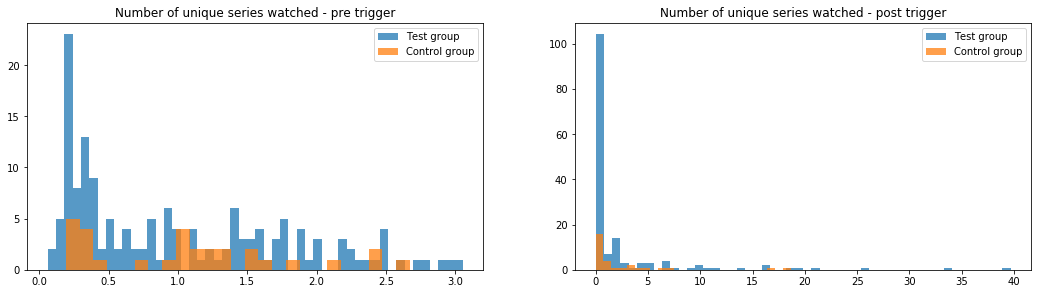

In [245]:
x = np.linspace(0,1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)

ax1.hist(test.precount, bins=50, alpha=0.75, label='Test group')
ax1.hist(control.precount, bins=25, alpha=0.75, label='Control group')
ax2.hist(test.postcount, bins=50, alpha=0.75, label='Test group')
ax2.hist(control.postcount, bins=25, alpha=0.75, label='Control group')

ax1.legend(); ax2.legend()
ax1.set_title('Number of unique series watched - pre trigger')
ax2.set_title('Number of unique series watched - post trigger')
plt.show()

Independent t-test between test & control pre-trigger should fail to reject null hypothesis as neither received mails. Fails to reject H0.

In [246]:
print ttest_ind(test.precount, control.precount)
print 'Critical T values:', t.interval(.95, len(test) + len(control) - 2)

Ttest_indResult(statistic=-0.62671811301040248, pvalue=0.53162935796792299)
Critical T values: (-1.9730840773322158, 1.9730840773322158)


Independent t-test between test & control post-trigger should reject null hypothesis as one group received mails. Fails to reject H0.

In [247]:
print ttest_ind(test.postcount, control.postcount)
print 'Critical T value:', t.interval(.95, len(test) + len(control) - 2)

Ttest_indResult(statistic=0.14936483622713032, pvalue=0.88143113972990539)
Critical T value: (-1.9730840773322158, 1.9730840773322158)


### Comparing Minutes

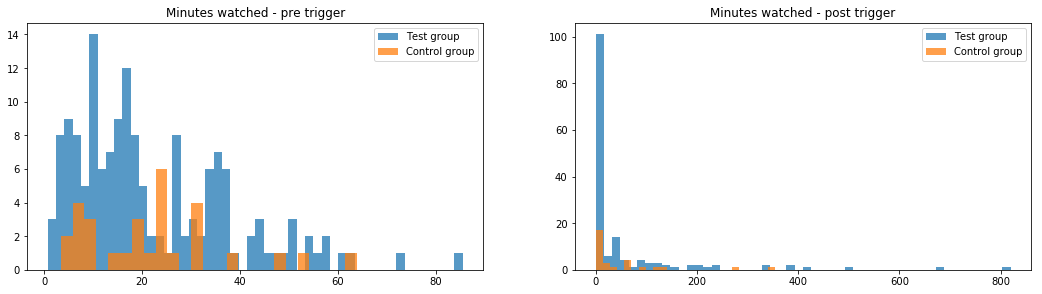

In [248]:
x = np.linspace(0,1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)

ax1.hist(test.preminutes, bins=50, alpha=0.75, label='Test group')
ax1.hist(control.preminutes, bins=25, alpha=0.75, label='Control group')
ax2.hist(test.postminutes, bins=50, alpha=0.75, label='Test group')
ax2.hist(control.postminutes, bins=25, alpha=0.75, label='Control group')

ax1.legend(); ax2.legend()
ax1.set_title('Minutes watched - pre trigger')
ax2.set_title('Minutes watched - post trigger')
plt.show()

Independent t-test between test & control pre-trigger should fail to reject null hypothesis as neither received mails. Fails to reject H0.

In [249]:
test.postminutes[test.postminutes>799] 

customernumber
899722991    819.777778
Name: postminutes, dtype: float64

In [254]:
#print pre.loc[899722991,:].sessionrecordduration
print post.loc[899722991,:].sessionrecordduration

351.333333334


In [256]:
data[data.customernumber== 899722991]#.sessionrecordduration.sum()

,customernumber,group,series,maildate,date,sessionrecordduration,programcrid
3087,899722991,test,Black-ish,2017-04-27,2017-04-19 20:57:15,20.716667,crid://telenet.be/AA/TN00037209_01_0011-OSNL-SD
3088,899722991,test,Black-ish,2017-04-27,2017-04-19 20:08:02,20.766667,crid://telenet.be/AA/TN00037209_01_0009-OSNL-SD
3089,899722991,test,Black-ish,2017-04-27,2017-04-19 20:36:07,20.716667,crid://telenet.be/AA/TN00037209_01_0010-OSNL-SD
3090,899722991,test,Black-ish,2017-04-27,2017-04-19 19:41:54,20.733333,crid://telenet.be/AA/TN00037209_01_0008-OSNL-SD
3091,899722991,test,Black-ish,2017-04-27,2017-04-18 20:46:17,19.916667,crid://telenet.be/AA/TN00037209_01_0005-OSNL-SD
3092,899722991,test,Black-ish,2017-04-27,2017-04-18 21:06:15,10.666667,crid://telenet.be/AA/TN00037209_01_0006-OSNL-SD
3093,899722991,test,Black-ish,2017-04-27,2017-04-18 20:15:30,15.200000,crid://telenet.be/AA/TN00037209_01_0004-OSNL-SD
3094,899722991,test,Black-ish,2017-04-27,2017-04-18 18:14:46,13.016667,crid://telenet.be/AA/TN00037209_01_0001-OSNL-SD
3095,899722991,test,Black-ish,2017-04-27,2017-04-18 19:32:57,16.616667,crid://telenet.be/AA/TN00037209_01_0003-OSNL-SD
3096,899722991,test,Black-ish,2017-04-27,2017-04-18 18:39:29,15.100000,crid://telenet.be/AA/TN00037209_01_0002-OSNL-SD


In [217]:
print ttest_ind(test.preminutes, control.preminutes)
print 'Critical T values:', t.interval(.95, len(test) + len(control) - 2)

Ttest_indResult(statistic=-0.18256485283956134, pvalue=0.85534266234815326)
Critical T values: (-1.9730840773322158, 1.9730840773322158)


Independent t-test between test & control post-trigger should reject null hypothesis as one group received mails. Fails to reject H0.

In [88]:
print ttest_ind(test.postminutes, control.postminutes)
print 'Critical T value:', t.interval(.95, len(test) + len(control) - 2)

Ttest_indResult(statistic=0.3553211830227988, pvalue=0.72276043903426312)
Critical T value: (-1.9730840773322158, 1.9730840773322158)


# Play More
### Load Data

In [89]:
playmore = pd.read_excel('query_result (63).xls')
print len(playmore), 'records'
playmore['date'] = playmore[['year', 'month', 'day']].apply(lambda s : datetime(*s), axis=1)
playmore.head()

17415 records


,customernumber,year,month,day,cnt_programs,sum_srd,date
0,12230585,2017,1,26,1,35.000000,2017-01-26
1,214177919,2017,1,15,3,72.933333,2017-01-15
2,214177919,2017,2,5,2,43.583333,2017-02-05
3,25594963,2017,1,6,2,113.750000,2017-01-06
4,47823121,2017,2,10,4,181.650000,2017-02-10


In [90]:
data = pd.merge(mails, playmore, on='customernumber', how='inner')
data = data[['customernumber', 'group', 'maildate', 'date', 'cnt_programs', 'sum_srd']]
print len(data), 'records'
data.sort_values('date', ascending=False).head()

17415 records


,customernumber,group,maildate,date,cnt_programs,sum_srd
11182,724766721,test,2017-04-21,2017-04-30,2,98.550000
11951,990003925,control,2017-04-27,2017-04-30,6,134.466667
15505,266575194,test,2017-04-21,2017-04-30,6,285.066667
13697,965559723,test,2017-04-21,2017-04-30,1,13.866667
1461,507305754,test,2017-04-21,2017-04-30,1,107.150000


### Retrieve viewing counts, minutes watched and averages

Viewings splitted pre and post trigger

In [173]:
pre = data[(data.maildate - data.date) > pd.Timedelta(0)]
post = data[(data.maildate - data.date) <= pd.Timedelta(0)]

Number of viewings and total minutes watched grouped per customer

In [174]:
pre = pre.groupby(['customernumber']).agg({'group':'min', 'cnt_programs':'sum', 'sum_srd':'sum', 'maildate':'min'})
post = post.groupby(['customernumber']).agg({'group':'min', 'cnt_programs':'sum', 'sum_srd':'sum', 'maildate':'min'})
pre.head()

,maildate,group,sum_srd,cnt_programs
customernumber,,,,
3070553,2017-04-27,test,13980.900000,338
5748056,2017-04-21,test,4846.150000,116
8823360,2017-04-21,test,46750.983333,1054
10664542,2017-04-21,test,9163.016667,278
12230585,2017-04-21,test,6945.566667,133


Merge pre and post to include zero values per customer

In [191]:
counts = pd.merge(pre, post, left_index=True, right_index=True, how='outer').fillna(0)
counts.drop(['group_y', 'maildate_y'], 1, inplace=True)
counts.columns=['maildate', 'group', 'preminutes', 'precount', 'postminutes', 'postcount']
counts.head(10)

,maildate,group,preminutes,precount,postminutes,postcount
customernumber,,,,,,
3070553,2017-04-27,test,13980.900000,338.0,535.250000,15.0
5748056,2017-04-21,test,4846.150000,116.0,753.033333,22.0
8823360,2017-04-21,test,46750.983333,1054.0,4010.616667,84.0
10664542,2017-04-21,test,9163.016667,278.0,710.233333,16.0
12230585,2017-04-21,test,6945.566667,133.0,817.733333,20.0
13607581,2017-04-21,control,15089.316667,313.0,1933.516667,42.0
14710250,2017-04-21,test,13424.866667,320.0,1798.400000,43.0
15678735,2017-04-21,test,17050.883333,387.0,1001.600000,22.0
16645503,2017-04-21,test,24553.766667,466.0,2104.166667,37.0


In [192]:
earliest = data.date.min()
latest = data.date.max()

counts['preweeks'] = counts.maildate.apply(lambda x: ((x - earliest).days) / float(7))
counts['postweeks'] = counts.maildate.apply(lambda x: ((latest - x).days) / float(7))

counts.precount = counts.precount / preweeks
counts.preminutes = counts.preminutes / preweeks
counts.postcount = counts.postcount / postweeks
counts.postminutes = counts.postminutes / postweeks

counts.head()

,maildate,group,preminutes,precount,postminutes,postcount,preweeks,postweeks
customernumber,,,,,,,,
3070553,2017-04-27,test,843.675000,20.396552,1248.916667,35.000000,16.571429,0.428571
5748056,2017-04-21,test,308.391364,7.381818,585.692593,17.111111,15.714286,1.285714
8823360,2017-04-21,test,2975.062576,67.072727,3119.368519,65.333333,15.714286,1.285714
10664542,2017-04-21,test,583.101061,17.690909,552.403704,12.444444,15.714286,1.285714
12230585,2017-04-21,test,441.990606,8.463636,636.014815,15.555556,15.714286,1.285714


In [193]:
test = counts[counts.group=='test']
control = counts[counts.group=='control']

In [194]:
print len(test), 'test records,', len(control), 'control records'
print (sum(test.preminutes) + sum(test.postminutes) + sum(control.preminutes) + sum(control.postminutes), sum(data.sum_srd))

155 test records, 32 control records
(415738.07820766675, 3268857.7666666382)


### Comparing Counts

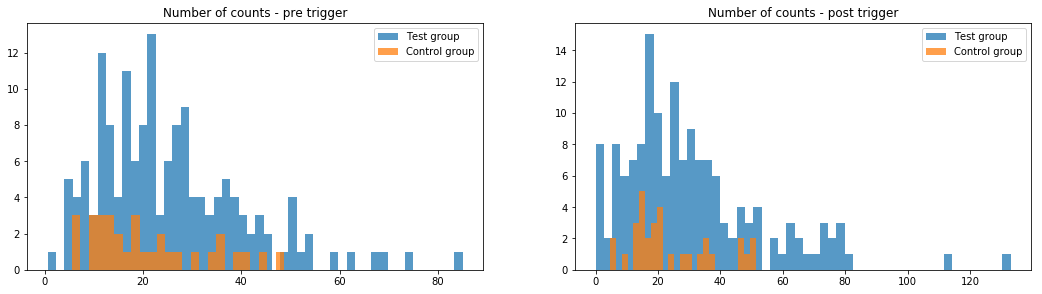

In [185]:
x = np.linspace(0,1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)

ax1.hist(test.precount, bins=50, alpha=0.75, label='Test group')
ax1.hist(control.precount, bins=25, alpha=0.75, label='Control group')
ax2.hist(test.postcount, bins=50, alpha=0.75, label='Test group')
ax2.hist(control.postcount, bins=25, alpha=0.75, label='Control group')

ax1.legend(); ax2.legend()
ax1.set_title('Number of counts - pre trigger')
ax2.set_title('Number of counts - post trigger')
plt.show()

Independent t-test between test & control pre-trigger should fail to reject null hypothesis as neither received mails. Fails to reject H0.

In [186]:
print ttest_ind(test.precount, control.precount)
print 'Critical T values:', t.interval(.95, len(test.precount) + len(control.precount) - 2)

Ttest_indResult(statistic=1.4884600167456039, pvalue=0.13833224735760394)
Critical T values: (-1.9728699462074988, 1.9728699462074988)


Independent t-test between test & control post-trigger should reject null hypothesis as one group received mails. Fails to reject H0.

In [187]:
print ttest_ind(test.postcount, control.postcount)
print 'Critical T values:', t.interval(.95, len(test.postcount) + len(control.postcount) - 2)

Ttest_indResult(statistic=1.5609212688843455, pvalue=0.12025134135943225)
Critical T values: (-1.9728699462074988, 1.9728699462074988)


### Comparing Minutes

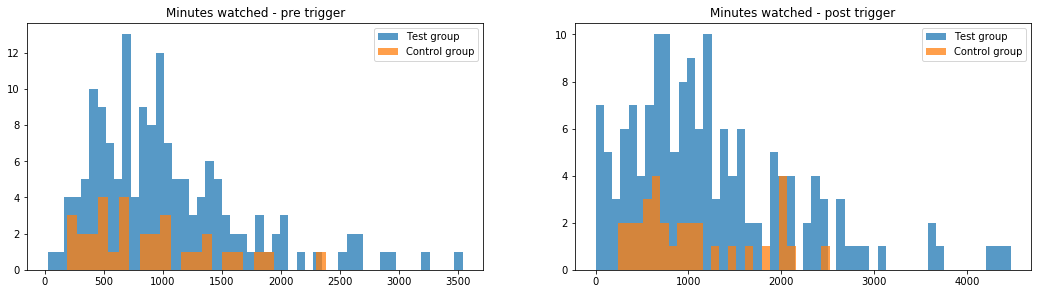

In [188]:
x = np.linspace(0,1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)

ax1.hist(test.preminutes, bins=50, alpha=0.75, label='Test group')
ax1.hist(control.preminutes, bins=25, alpha=0.75, label='Control group')
ax2.hist(test.postminutes, bins=50, alpha=0.75, label='Test group')
ax2.hist(control.postminutes, bins=25, alpha=0.75, label='Control group')

ax1.legend(); ax2.legend()
ax1.set_title('Minutes watched - pre trigger')
ax2.set_title('Minutes watched - post trigger')
plt.show()

Independent t-test between test & control pre-trigger should fail to reject null hypothesis as neither received mails. Fails to reject H0.

In [189]:
print ttest_ind(test.preminutes, control.preminutes)
print 'Critical T values:', t.interval(.95, len(test) + len(control) - 2)

Ttest_indResult(statistic=1.1732013956334171, pvalue=0.24222335189729957)
Critical T values: (-1.9728699462074988, 1.9728699462074988)


Independent t-test between test & control post-trigger should reject null hypothesis as one group received mails. Fails to reject H0.

In [190]:
print ttest_ind(test.postminutes, control.postminutes)
print 'Critical T value:', t.interval(.95, len(test) + len(control) - 2)

Ttest_indResult(statistic=1.0697839021541378, pvalue=0.28611037106492243)
Critical T value: (-1.9728699462074988, 1.9728699462074988)
